<b><span style="font-size:210%">목차</span></b> <br>

0. <b><span style="font-size:110%">라이브러리 및 데이터 로드<br></span> </b> 
1. <b><span style="font-size:110%">Basic EDA<br></span> </b> 
    1-1. Noise 처리<br>
    <span style="font-size:90%">1) 임대료,임대보증금<br></span>
    1-2. 라벨 변경<br>
    <span style="font-size:90%">1) 지하철역수, 버스정류장수<br></span>
2. <b><span style="font-size:110%">Continuous variables <br></span></b>
    2-1. 상관분석<br>
    2-2. 분포확인<br>
3. <b><span style="font-size:110%">Categorical variables<br></span></b>
   3-1. 상관분석<br>
   3-2. 분포확인<br>
4. <b><span style="font-size:110%"> 데이터 전처리</span> <br></b>
   4-1. 결측치 대체<br>
    <span style="font-size:90%">1)임대료, 임대보증금<br></span>   

# 0. 라이브러리 및 데이터 로드

In [ ]:
install.packages(c("dplyr","ggplot2","corrplot")) #전처리
install.packages("mice")#imputation

In [ ]:
pacman::p_load( "dplyr","ggplot2","corrplot","mice")

In [ ]:
options(encoding="utf-8")

In [ ]:
train=read.csv("train.csv", sep=',', header=T)

# 1. Basic EDA

In [4]:
str(train)

'data.frame':	2952 obs. of  15 variables:
 $ 단지코드                                      : Factor w/ 423 levels "C1000","C1004",..: 358 358 358 358 358 358 358 358 372 372 ...
 $ 총세대수                                      : int  900 900 900 900 900 900 900 900 545 545 ...
 $ 임대건물구분                                  : Factor w/ 2 levels "상가","아파트": 2 2 2 2 2 2 2 2 2 2 ...
 $ 지역                                          : Factor w/ 16 levels "강원도","경기도",..: 4 4 4 4 4 4 4 4 3 3 ...
 $ 공급유형                                      : Factor w/ 10 levels "공공분양","공공임대(10년)",..: 6 6 6 6 6 6 6 6 6 6 ...
 $ 전용면적                                      : num  39.7 39.7 51.9 51.9 51.9 ...
 $ 전용면적별세대수                              : int  134 15 385 15 41 89 135 86 276 60 ...
 $ 공가수                                        : num  38 38 38 38 38 38 38 38 17 17 ...
 $ 자격유형                                      : Factor w/ 15 levels "A","B","C","D",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ 임대보증금                                  

1. `관찰 값` **총 2952개**,**15차원** `타겟 변수` **'등록차량수'**를 제외한 `피처`는 **총 14개**다.
2. `'Target'` 정수, 같은 값 반복 -> duplicated 확인 필요
2. `'Continuous variables'` 총 8개
    - 총세대수, 전용면적, 전용면적별세대수, 공가수, 지하철역수, 버스정류장수, 단지내주차면수, 등록차량수(타켓)
    - rename 필요성 : 지하철역수(12), 버스정류장수(13)
3. `'Categorical variables'` 총 7개
    - 단지코드, 임대건물구분(레벨2), 지역(레벨16), 공급유형(레벨10), 자격유형(레벨15)
    - 임대보증금과 임대료는 결측치로 인해 factor로 처리됨 **R에서는 CHAR로 나옴**
    - 나머지 모두 순서를 가지지 않음 -> 스피어만 확인할 필요 X

In [5]:
summary(train)

    단지코드       총세대수      임대건물구분          지역     
 C1439  :  48   Min.   :  26.0   상가  : 562   경기도    : 621  
 C2132  :  47   1st Qu.: 513.5   아파트:2390   경상남도  : 369  
 C1859  :  40   Median : 779.0                 부산광역시: 328  
 C1790  :  33   Mean   : 886.7                 대전광역시: 266  
 C2597  :  32   3rd Qu.:1106.0                 강원도    : 187  
 C1874  :  30   Max.   :2568.0                 충청북도  : 163  
 (Other):2722                                  (Other)   :1018  
           공급유형       전용면적      전용면적별세대수     공가수     
 국민임대      :1758   Min.   : 12.62   Min.   :   1.0   Min.   : 0.00  
 임대상가      : 562   1st Qu.: 32.10   1st Qu.:  14.0   1st Qu.: 4.00  
 행복주택      : 213   Median : 39.93   Median :  60.0   Median :11.00  
 공공임대(10년): 205   Mean   : 44.76   Mean   : 102.7   Mean   :12.92  
 영구임대      : 152   3rd Qu.: 51.56   3rd Qu.: 144.0   3rd Qu.:20.00  
 공공임대(50년):  31   Max.   :583.40   Max.   :1865.0   Max.   :55.00  
 (Other)       :  31                                       

1. rename: 12,13 colname 변경하기 `EDA`
2. 임대보증금, 임대료 int로 class 변환하기 `EDA`
3. 임대보증금, 임대료, 지하철역, 버스정류장 NA확인 `EDA` imputation `Preprocessing`
4. 단지내주차면수와 TARGET 양상관인 것 같음(IQR만 봤을 때) ->확인 필요 `EDA`
5. 스케일 필요한가? `Feature Enginnering`   
6. 도보 10분거리 내 버스정류장 수 20개는 상식적으로 Potential Ouliers 의심 가능 `Preprocessing`

In [6]:
summary(train$임대료)

-  390000   79980  100920  167230  151110  590000  149810  187260 
    569      21      19      18      16      15      14      14      13      13 
 450000  111470  142310  232200  257660   94990  144180  164770  172190  291110 
     13      12      12      12      12      12      11      10      10      10 
 102130  162250  470000   69900  106090  136250  168520  179620  188260  217210 
      9       9       9       9       8       8       8       8       8       8 
 360000  550000  105280  111090  161020  189130  192250  198250  215550  221980 
      8       8       7       7       7       7       7       7       7       7 
 340790  520000  580000  585000  620000   99000  102350  110110  110530  132430 
      7       7       7       7       7       7       6       6       6       6 
 148630  161290  164610  175900  176230  184330  232000  240470  264350  275900 
      6       6       6       6       6       6       6       6       6       6 
 283920  284650  304540  338840  460000  520500   83020   87710   90110  104840 
      6       6       6       6       6       6       6       6       6       5 
 107200  110500  118320  124830  135010  141770  150190  162390  170940  172280 
      5       5       5       5       5       5       5       5       5       5 
 193550  206110   21120  235360  259660  269610  291970  312610  373340   43380 
      5       5       5       5       5       5       5       5       5       5 
  73320   81540   87960   87980   92900  100690  113950  116430  117270 (Other) 
      5       5       5       5       5       4       4       4       4    1644

In [6]:
summary(train$임대보증금)

24775000 14418000  5787000 18726000 43000000 17342000 19819000 
     569       22       21       18       17       17       16       15 
32443000 39000000 24665000        - 14863000 17477000 21221000 34810000 
      15       14       13       12       12       12       12       12 
 6873000 15620000 61000000 13625000 26217000 34082000 44348000 12015000 
      12       11       11       10       10       10       10        9 
19572000 19973000 22173000 22471000 26014000 28491000 31210000  3141000 
       9        9        9        9        9        9        9        9 
44000000 57000000 15729000 16102000 18581000 21555000 24093000 24402000 
       9        9        8        8        8        8        8        8 
25233000 31958000 37164000 43357000 43990000 12392000 12483000 13979000 
       8        8        8        8        8        7        7        7 
19225000 23720000 31711000 45613000 55000000 63000000  9908000 12947000 
       7        7        7        7        7        7        7        6 
13007000 16225000 17451000 20221000 21628000 23281000 23370000 23520000 
       6        6        6        6        6        6        6        6 
24969000 27465000 28199000 32459000 35462000 36036000 36048000  3731000 
       6        6        6        6        6        6        6        6 
37454000 41697000 43819000 54000000 54132000 65000000 69600000 75000000 
       6        6        6        6        6        6        6        6 
11147000 12571000 13022000 13533000 13731000 15577000 16520000 16723000 
       5        5        5        5        5        5        5        5 
18175000 18968000 19720000 20439000 26000000 27304000 27637000 29551000 
       5        5        5        5        5        5        5        5 
35455000 36122000 37163000  (Other) 
       5        5        5     1579

In [7]:
nrow(duplicated(train))  #중복확인

NULL

## 1-1.  Noise 처리

1) 임대료, 임대보증금

In [16]:
summary(train$임대료)   #RGUI에선 캐릭터로 나옴

-  390000   79980  100920  167230  151110  590000  149810  187260 
    569      21      19      18      16      15      14      14      13      13 
 450000  111470  142310  232200  257660   94990  144180  164770  172190  291110 
     13      12      12      12      12      12      11      10      10      10 
 102130  162250  470000   69900  106090  136250  168520  179620  188260  217210 
      9       9       9       9       8       8       8       8       8       8 
 360000  550000  105280  111090  161020  189130  192250  198250  215550  221980 
      8       8       7       7       7       7       7       7       7       7 
 340790  520000  580000  585000  620000   99000  102350  110110  110530  132430 
      7       7       7       7       7       7       6       6       6       6 
 148630  161290  164610  175900  176230  184330  232000  240470  264350  275900 
      6       6       6       6       6       6       6       6       6       6 
 283920  284650  304540  338840  460000  520500   83020   87710   90110  104840 
      6       6       6       6       6       6       6       6       6       5 
 107200  110500  118320  124830  135010  141770  150190  162390  170940  172280 
      5       5       5       5       5       5       5       5       5       5 
 193550  206110   21120  235360  259660  269610  291970  312610  373340   43380 
      5       5       5       5       5       5       5       5       5       5 
  73320   81540   87960   87980   92900  100690  113950  116430  117270 (Other) 
      5       5       5       5       5       4       4       4       4    1644

In [9]:
#train$임대료<-as.numeric(train$임대료)
#train$임대보증금<-as.numeric(train$임대보증금)

In [10]:
#summary(train$임대료) #

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    61.0   369.0   399.6   696.2   996.0 

- 값이 이상함 

In [22]:
#train$임대료<-ifelse(  train$임대료=="-" |  train$임대료==1 , 0, train$임대료   )
#train$임대보증금<-ifelse(train$임대보증금==1 | train$임대보증금=="-" , 0, train$임대보증금   )

In [23]:
#summary(train$임대료)
#summary(train$임대보증금)   # 역시 이상함

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    61.0   369.0   399.6   696.2   996.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   79.75  370.50  389.08  661.00  958.00 

In [12]:
sum(is.na(train$임대료));sum(is.na(train$임대보증금))

[1] 0

[1] 0

- 역시 이상함 -> **R에서 처리**

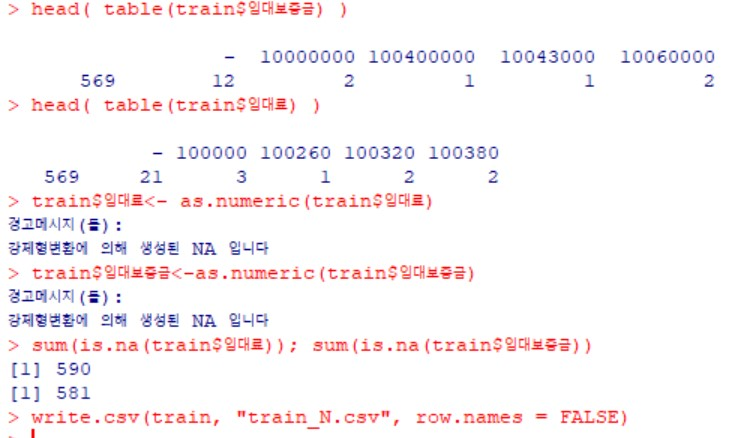

In [2]:
options(encoding="utf-8")
train=read.csv("train_n.csv", sep=',', header=T)

In [3]:
summary(train) # 반영완료

    단지코드       총세대수      임대건물구분          지역     
 C1439  :  48   Min.   :  26.0   상가  : 562   경기도    : 621  
 C2132  :  47   1st Qu.: 513.5   아파트:2390   경상남도  : 369  
 C1859  :  40   Median : 779.0                 부산광역시: 328  
 C1790  :  33   Mean   : 886.7                 대전광역시: 266  
 C2597  :  32   3rd Qu.:1106.0                 강원도    : 187  
 C1874  :  30   Max.   :2568.0                 충청북도  : 163  
 (Other):2722                                  (Other)   :1018  
           공급유형       전용면적      전용면적별세대수     공가수     
 국민임대      :1758   Min.   : 12.62   Min.   :   1.0   Min.   : 0.00  
 임대상가      : 562   1st Qu.: 32.10   1st Qu.:  14.0   1st Qu.: 4.00  
 행복주택      : 213   Median : 39.93   Median :  60.0   Median :11.00  
 공공임대(10년): 205   Mean   : 44.76   Mean   : 102.7   Mean   :12.92  
 영구임대      : 152   3rd Qu.: 51.56   3rd Qu.: 144.0   3rd Qu.:20.00  
 공공임대(50년):  31   Max.   :583.40   Max.   :1865.0   Max.   :55.00  
 (Other)       :  31                                       

- `NA 정리완료` 
    임대료 590, 임대보증금 581, 지하철역수 211, 버스정류장수 4 -> `Preprocessing`

## 1-2. 라벨 변경

1) 지하철역수, 버스정류장수

In [4]:
names(train)[c(12,13)] <-c("지하철역수", "버스정류장수")
colnames(train)

[1] "단지코드"         "총세대수"         "임대건물구분"     "지역"            
 [5] "공급유형"         "전용면적"         "전용면적별세대수" "공가수"          
 [9] "자격유형"         "임대보증금"       "임대료"           "지하철역수"      
[13] "버스정류장수"     "단지내주차면수"   "등록차량수"

# 2. EDA for Continuous variables 
-총세대수[,2], 전용면적[,6], 전용면적별세대수[,7], 공가수[,8], 임대보증금[,10], 임대료[,11], 지하철역수[,12], 버스정류장수[,13], 단지내주차면수[,14], 등록차량수[,15](TARGET)

- 설명변수 14개 중 `9개`

- 반응변수 `1개`


## 2-1. Correlation

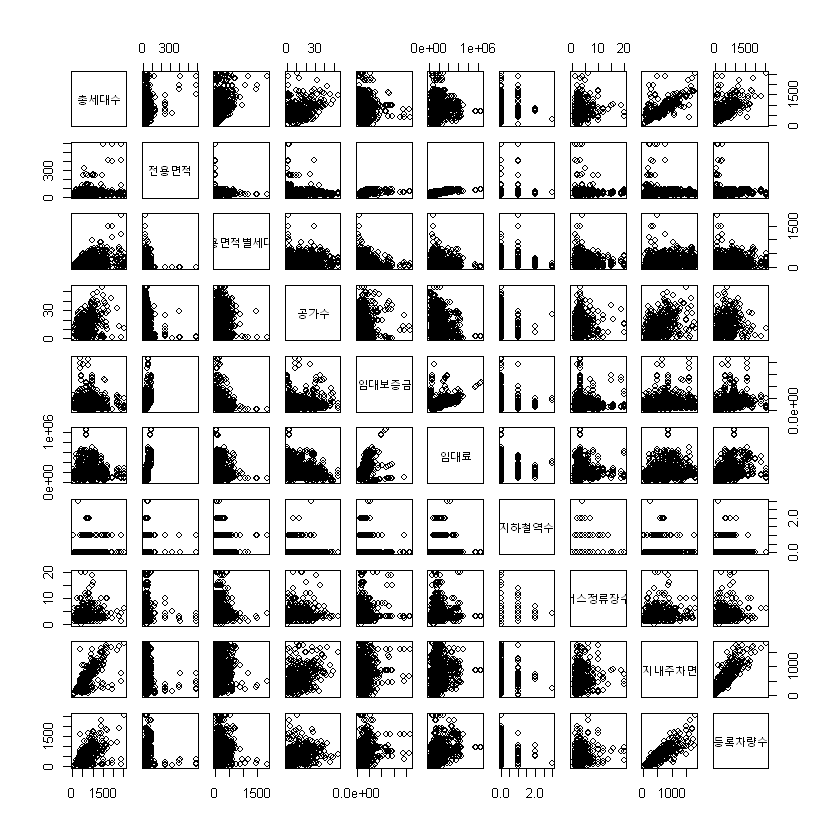

In [6]:
cont<-data.frame( train[,c(2,6:8,10:11, 12:15)])  
pairs(cont)

- **타겟**과의 눈에띄는 선형성 `총세대수`, `단지내주차면적수`, `공가수`
- **피처끼리** 눈에 띄는 선형성 (총세대수, 단지내주차면수)


  There is a binary version available but the source version is later:
         binary source needs_compilation
corrplot   0.88   0.92             FALSE



installing the source package 'corrplot'



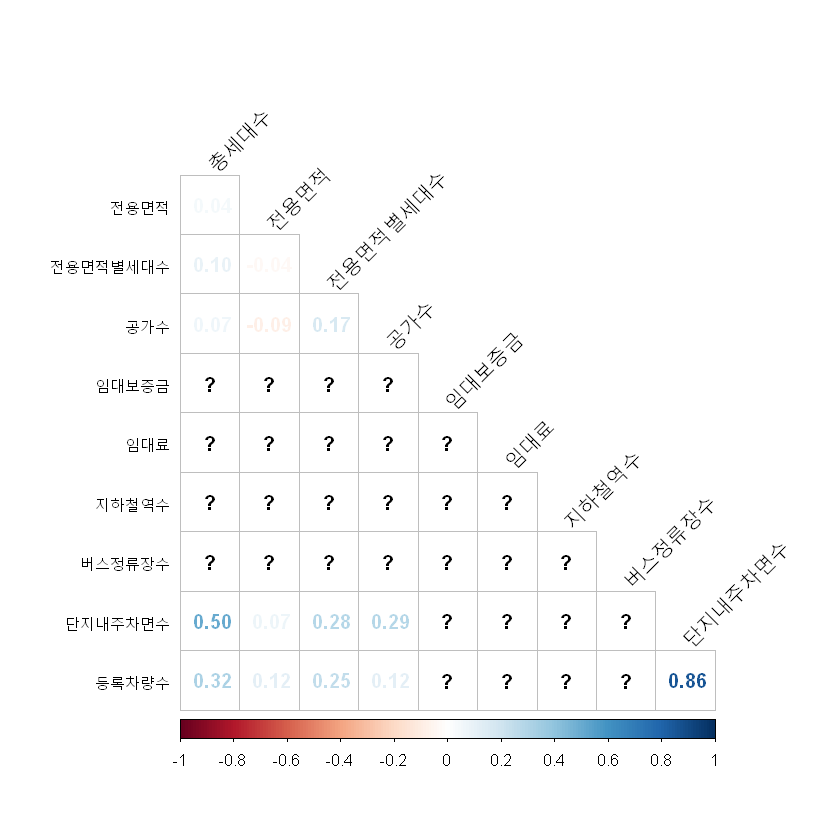

In [7]:
cont.cor<-cor(cont) 
corrplot(cont.cor, method="number",  type = "lower" ,addCoef.col = "black" ,  tl.col = "black", tl.srt = 45, diag = F) 

1. 지하철역수, 버스정류장수, 임대료, 임대보증금 NA 처리전 -> `Preprocessing` 후 다시
2. **단지내주차면수**와 등록차량수 매우 유의한 상관관계 **중요변수 예상**
3. 임대보증금, 임대료 IMPUTATION한다면 상식적으로 **높은 상관관계 예상**

## 2-2. Distribution

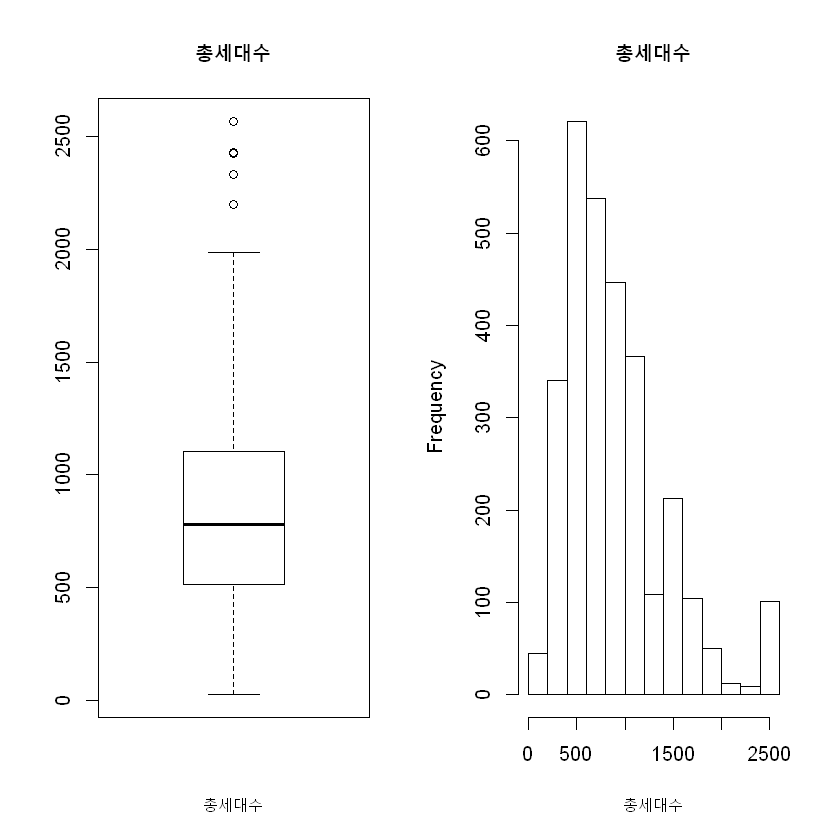

In [9]:
#총세대수(2)
par(mfcol=c(1,2))
boxplot(train[,2],main=names(train)[2], xlab=names(train)[2])
hist(train[,2], main=names(train)[2], xlab=names(train)[2] )

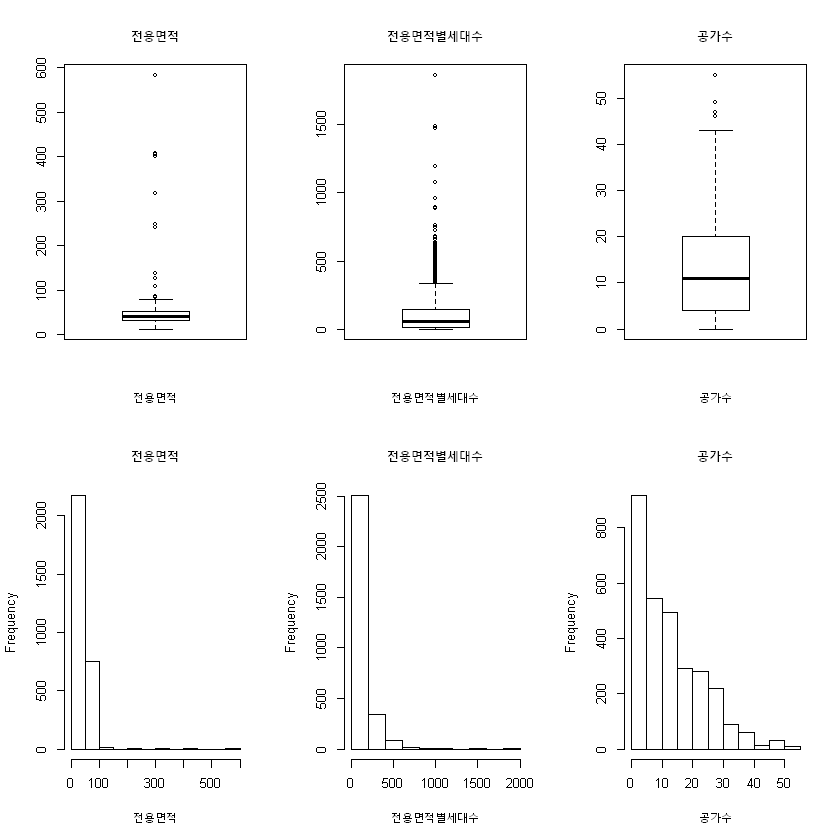

In [10]:
# 전용면적(6), 전용면적별세대수(7), 공가수(8)
par(mfcol=c(2,3))
for (j in 6:8) { 
boxplot(train[,j] , main=names(train)[j],  xlab=names(train)[j] )  
hist(train[,j] , main=names(train)[j] , xlab=names(train)[j] )
}


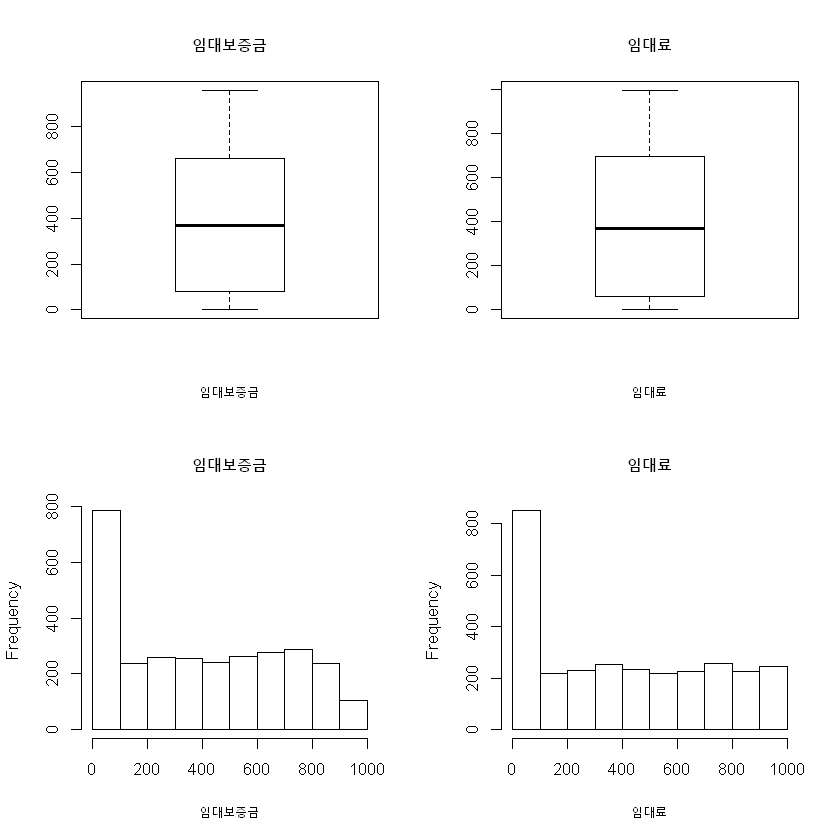

In [11]:
#임대보증금(10), 임대료(11)
par(mfcol=c(2,2))
for (j in 10:11) { 
boxplot(train[,j] , main=names(train)[j],  xlab=names(train)[j] )  
hist(train[,j] , main=names(train)[j] , xlab=names(train)[j] )
}


역시 `신뢰할 수 없는` 결과 나옴

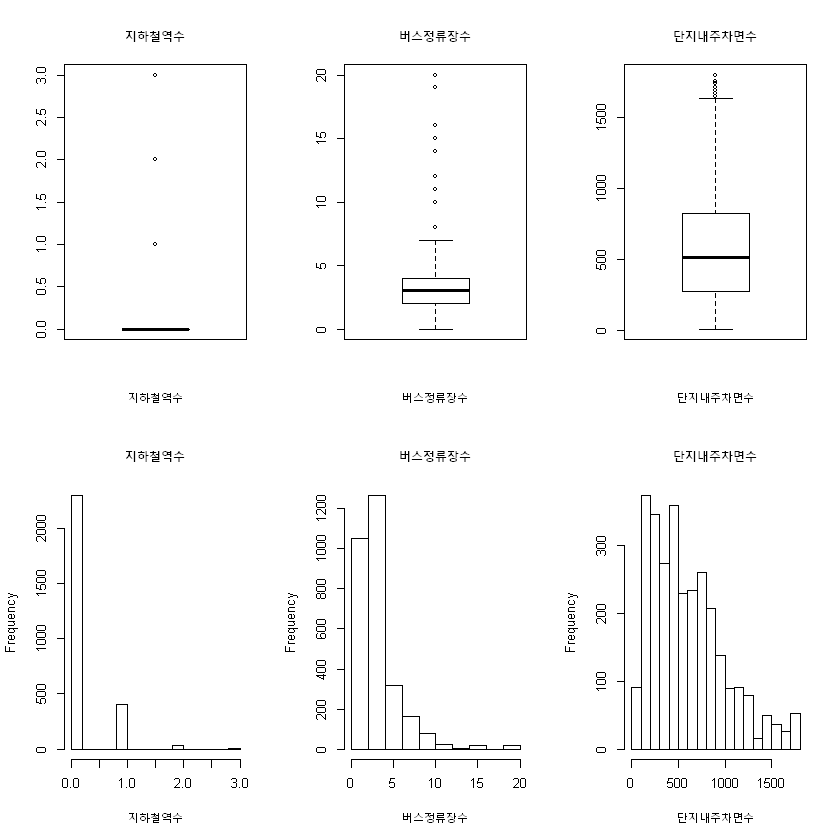

In [12]:
#지하철역수(12), 버스정류장수(13), 단지내주차면수(14)
par(mfcol=c(2,3))
for (j in 12:14) { 
boxplot(train[,j] , main=names(train)[j],  xlab=names(train)[j] )  
hist(train[,j] , main=names(train)[j] , xlab=names(train)[j] )
}

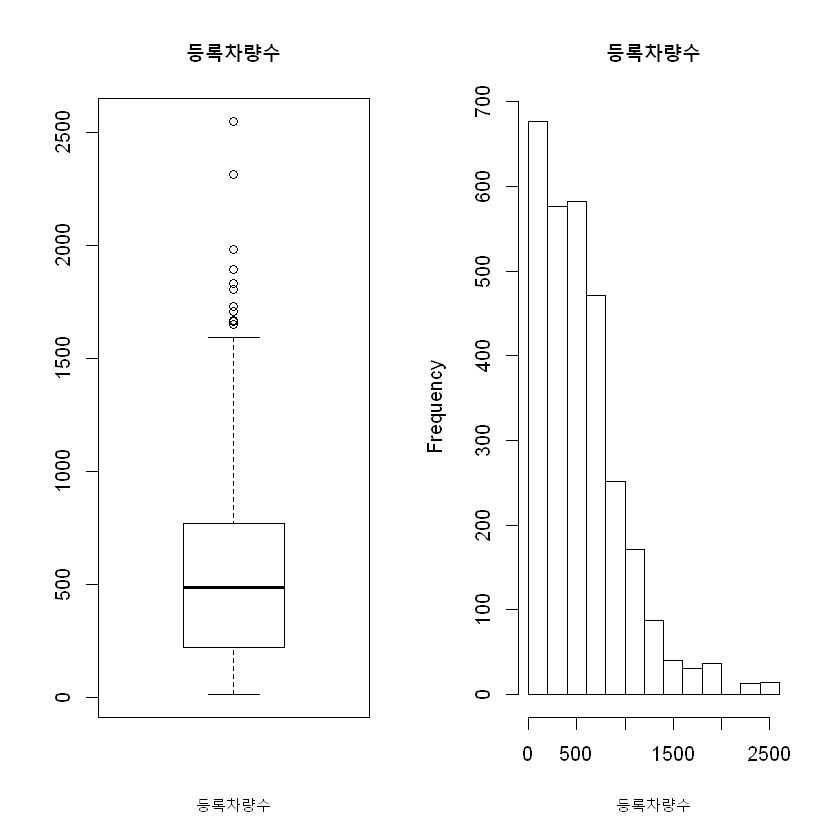

In [13]:
#등록차량수(TARGET)
par(mfcol=c(1,2))
boxplot(train[,15],main=names(train)[15], xlab=names(train)[15])
hist(train[,15], main=names(train)[15], xlab=names(train)[15] )

# 3. EDA for Categorical variables

-단지코드(1), 임대건물구분(3), 지역(4), 공급유형(5), 자격유형(9)

- 설명변수 14개 중 `5개`


## 3-1. Correlation
 -범주형변수 모두 순위가 없는 명목형이므로 spearman 역시 이용하지 않음

## 3-2. Distribution


C1000 C1004 C1005 C1013 C1014 C1015 
    7    19     3     5     7     8 

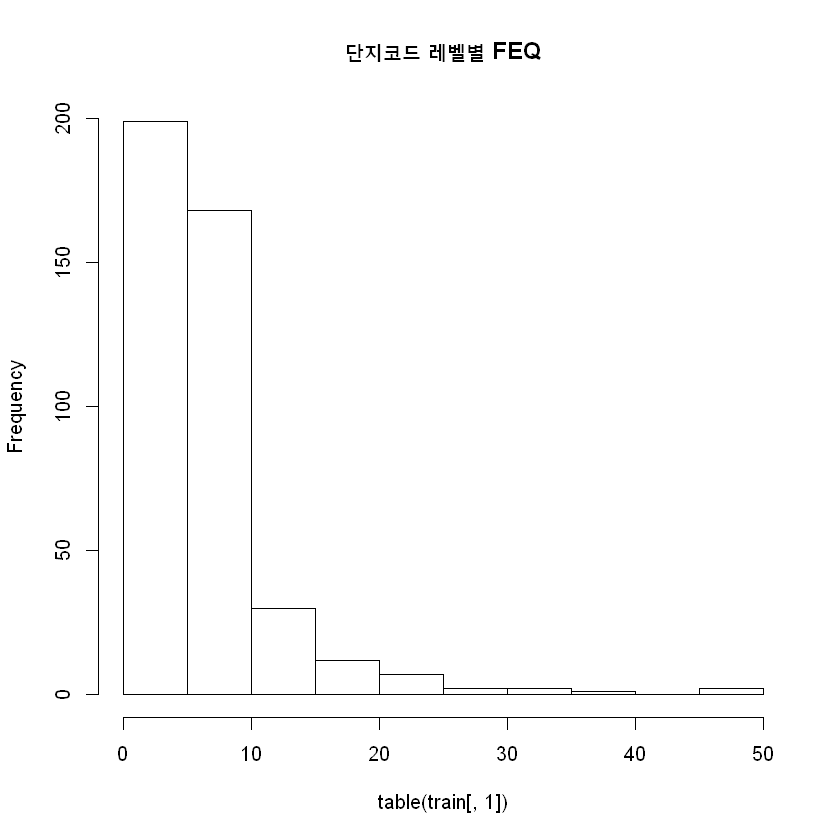

In [14]:
#단지코드(1) 423levels 레벨 너무 많음
#table(train[,1])
head(table(train[,1]))
hist( table(train[,1]) ,main="단지코드 레벨별 FEQ" )

In [15]:
df<-data.frame(table(train[,1]))  
o<-order(df$Freq, decreasing=T)
head(df[o,],5)
tail(df[o,],5)


,Var1,Freq
101,C1439,48
270,C2132,47
191,C1859,40
179,C1790,33
401,C2597,32


,Var1,Freq
415,C2651,2
285,C2188,1
320,C2340,1
348,C2437,1
374,C2520,1


- 어떤 아파트에서는 48번 샘플링됨
- 어떤 아파트에서는 1번 샘플링됨
     
뭔가 이상함 전용면적별세대수만 제외하면 duplicated됨 **전용면적별세대수 정의 필요**



  There is a binary version available but the source version is later:
        binary source needs_compilation
ggplot2  3.3.3  3.3.5             FALSE



installing the source package 'ggplot2'



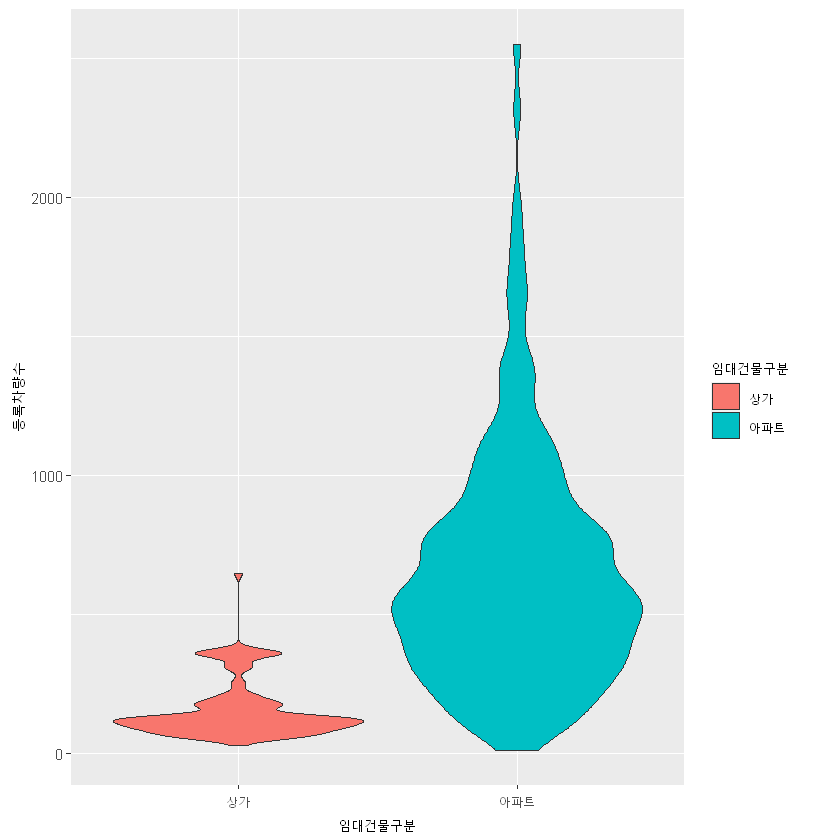

In [16]:
#임대건물구분(3)
ggplot(train,
       aes(x=임대건물구분,
           y=등록차량수, fill=임대건물구분))+
  geom_violin(scale='width')


- 아파트가 눈에 뛰게 등록차량수 많음(make sense)
- 어떤 범위까지는 등록차량수가 적으면 상가, 많으면 아파트 


  상가 아파트 
   562   2390 

train[, 3]
      상가     아파트 
0.05387017 0.94612983 

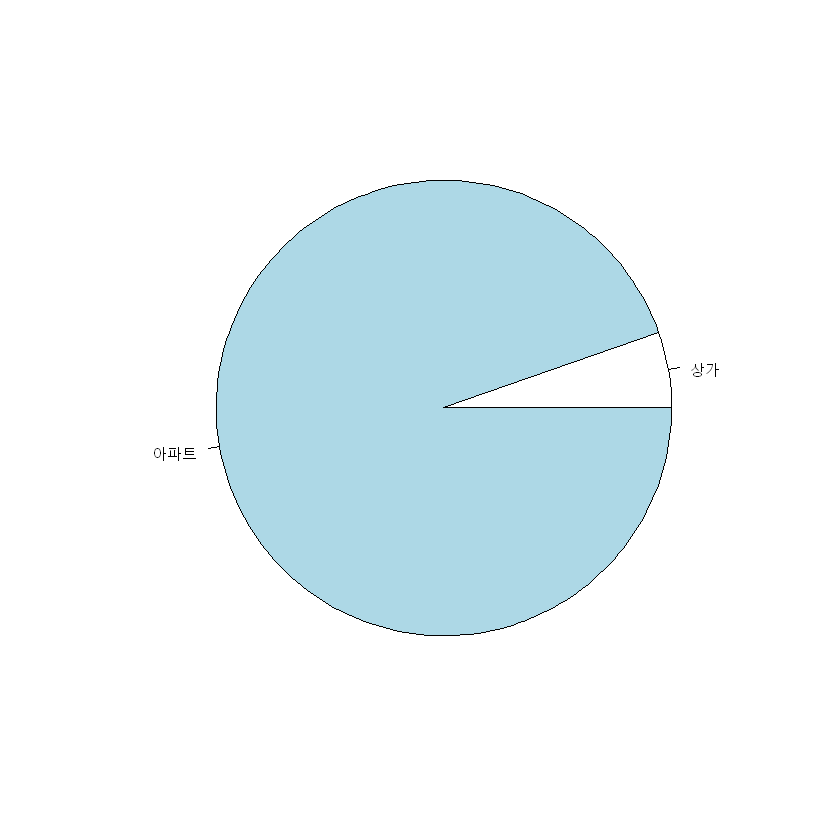

In [17]:
table(train[,3])
tb<-with(train,xtabs(등록차량수~train[,3]))
prop.table(tb)
pie(prop.table(tb))


        강원도         경기도       경상남도       경상북도     광주광역시 
           187            621            369            119            141 
    대구광역시     대전광역시     부산광역시     서울특별시 세종특별자치시 
           102            266            328             64             47 
    울산광역시       전라남도       전라북도 제주특별자치도       충청남도 
            36            151            109             91            158 
      충청북도 
           163 

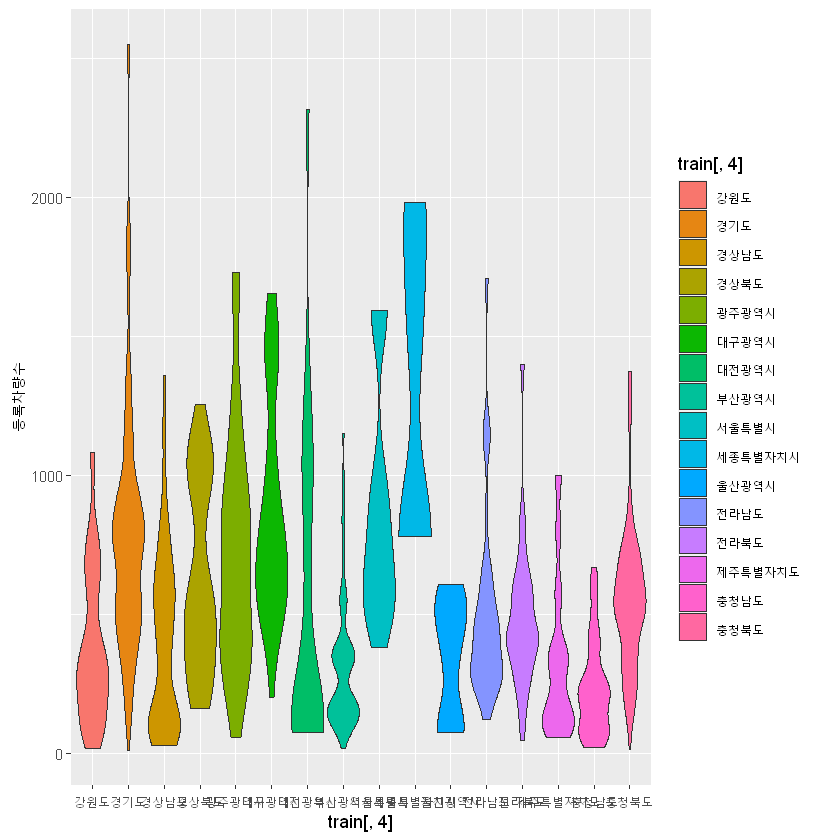

In [18]:
#지역(4)
table(train[,4])

ggplot(train,
       aes(x=train[,4],
           y=등록차량수, fill=train[,4]))+
  geom_violin(scale='width')

- 울산,세종,서울 특히 **세종**은 최소등록차량수 수치가 비교적 큼
- 경기도 ,대구 최대등록차량수 수치 비교적 큼
- 울산 최대등록자량수 수치 눈에뛰게 작음
- 경상남도와 경상북도는 분포가 비슷함 -> `경상도` 범주 조정 가능성
- 전남 전북 분포 비교적 비슷하다고 할수 있음 -> `전라도` 범주 조정 가능성
- 충남 충북 분포 다름


        강원도         경기도       경상남도       경상북도     광주광역시 
           187            621            369            119            141 
    대구광역시     대전광역시     부산광역시     서울특별시 세종특별자치시 
           102            266            328             64             47 
    울산광역시       전라남도       전라북도 제주특별자치도       충청남도 
            36            151            109             91            158 
      충청북도 
           163 

train[, 4]
        강원도         경기도       경상남도       경상북도     광주광역시 
   0.043936346    0.298686908    0.092502221    0.046148837    0.062448409 
    대구광역시     대전광역시     부산광역시     서울특별시 세종특별자치시 
   0.053919789    0.086184881    0.062832691    0.034173184    0.036792348 
    울산광역시       전라남도       전라북도 제주특별자치도       충청남도 
   0.007466552    0.046314048    0.031822110    0.018350484    0.022867451 
      충청북도 
   0.055553740 

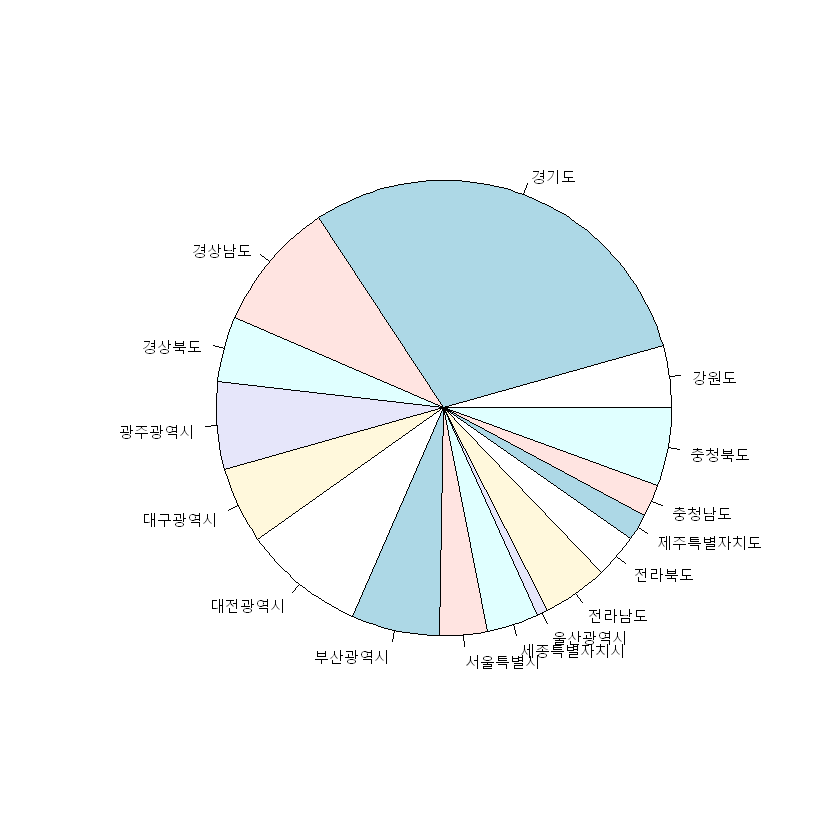

In [19]:
table(train[,4])
tb<-with(train,xtabs(등록차량수~train[,4]))
prop.table(tb)
pie(prop.table(tb))


      공공분양 공공임대(10년) 공공임대(50년)  공공임대(5년) 공공임대(분납) 
             7            205             31              3             12 
      국민임대       영구임대       임대상가       장기전세       행복주택 
          1758            152            562              9            213 

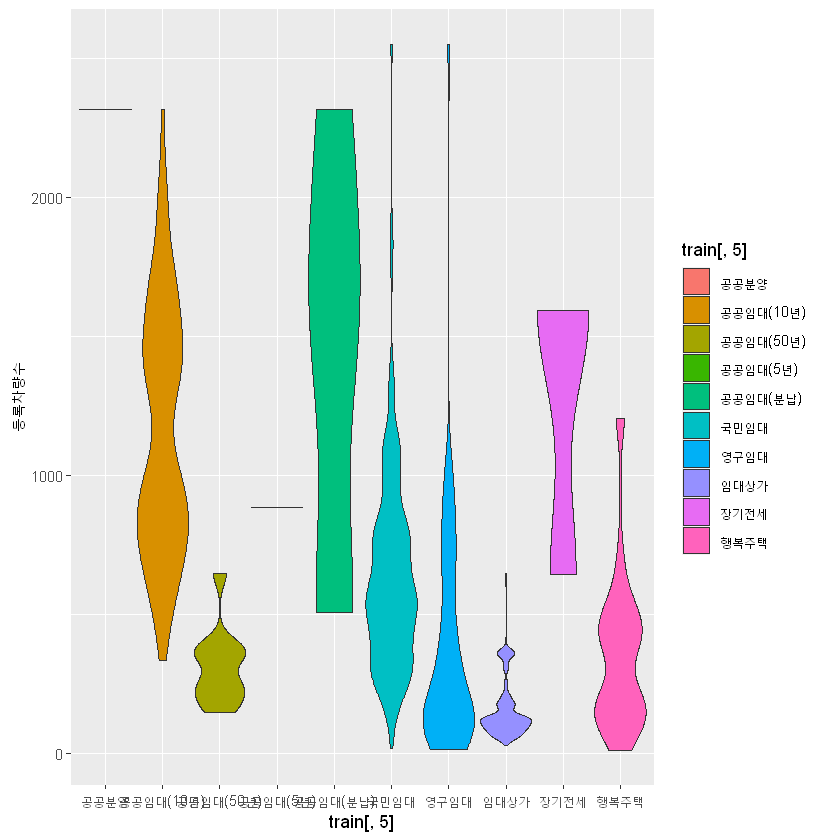

In [20]:
#공급유형(5)
table(train[,5])

ggplot(train,
       aes(x=train[,5],
           y=등록차량수, fill=train[,5]))+
  geom_violin(scale='width')


      공공분양 공공임대(10년) 공공임대(50년)  공공임대(5년) 공공임대(분납) 
             7            205             31              3             12 
      국민임대       영구임대       임대상가       장기전세       행복주택 
          1758            152            562              9            213 

train[, 5]
      공공분양 공공임대(10년) 공공임대(50년)  공공임대(5년) 공공임대(분납) 
   0.009806734    0.143875466    0.005893723    0.001610350    0.010261214 
      국민임대       영구임대       임대상가       장기전세       행복주택 
   0.685806894    0.034967164    0.053870165    0.006962448    0.046945842 

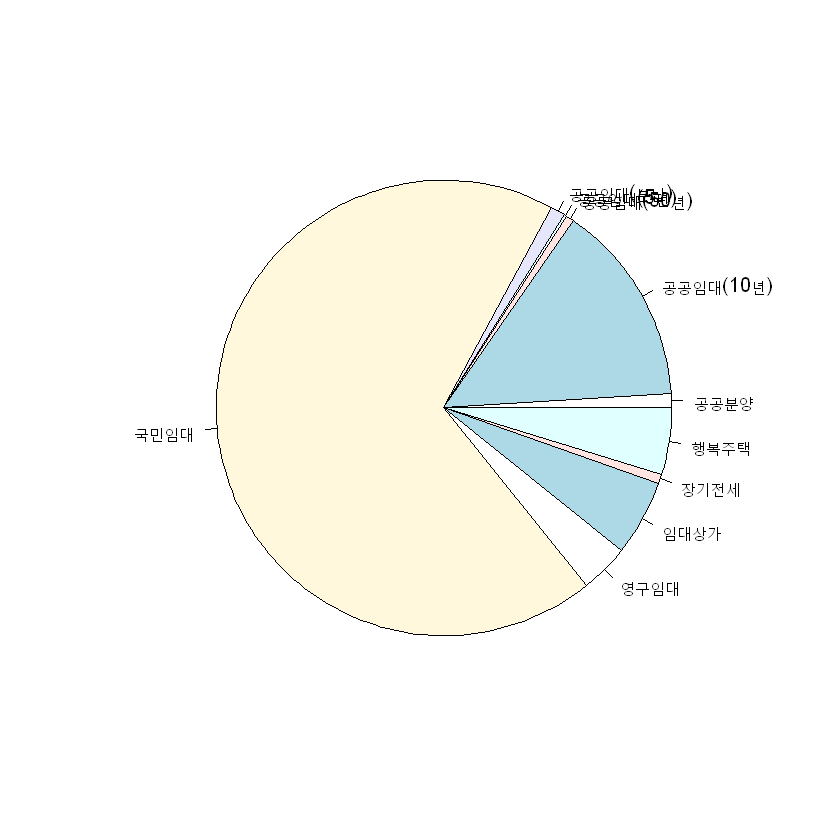

In [21]:
table(train[,5])
tb<-with(train,xtabs(등록차량수~train[,5]))
prop.table(tb)
pie(prop.table(tb))


   A    B    C    D    E    F    G    H    I    J    K    L    M    N    O 
1801   21   95  569   37    3    9  155   49  114   33   33    2   30    1 

Warning message:
"Groups with fewer than two data points have been dropped."

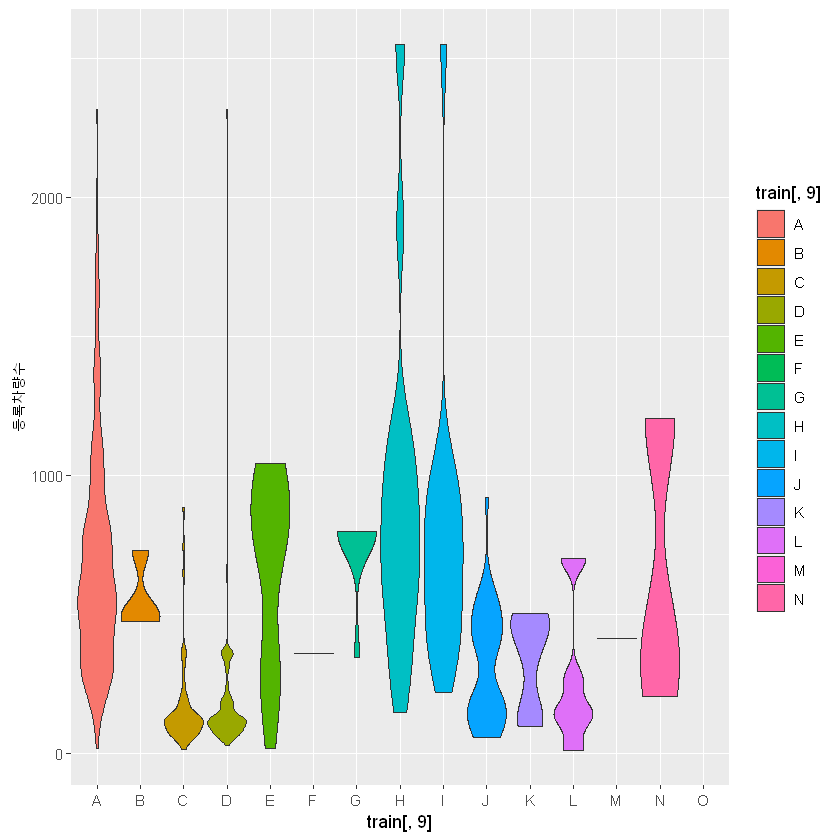

In [22]:
#자격유형(9)
table(train[,9])
 ggplot(train,
       aes(x=train[,9],
           y=등록차량수, fill=train[,9]))+
  geom_violin(scale='width')


   A    B    C    D    E    F    G    H    I    J    K    L    M    N    O 
1801   21   95  569   37    3    9  155   49  114   33   33    2   30    1 

train[, 9]
           A            B            C            D            E            F 
0.7439071770 0.0071318950 0.0098956934 0.0636768988 0.0149155550 0.0006517650 
           G            H            I            J            K            L 
0.0040770112 0.0857473451 0.0230508171 0.0217630214 0.0066314217 0.0055427260 
           M            N            O 
0.0005034991 0.0122534246 0.0002517495 

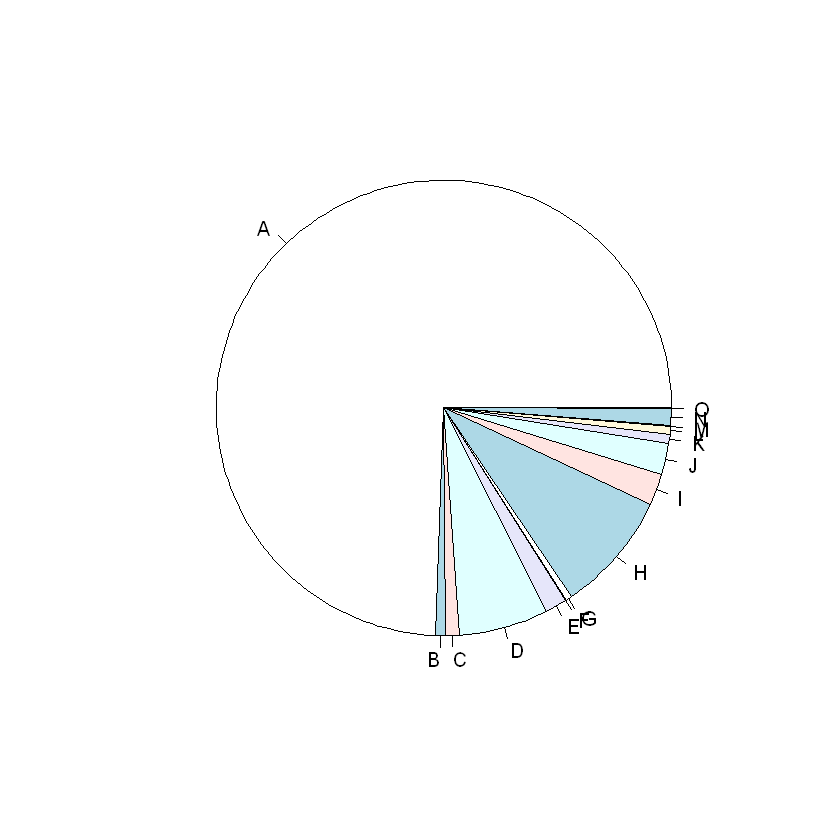

In [23]:
table(train[,9])
tb<-with(train,xtabs(등록차량수~train[,9]))
prop.table(tb)
pie(prop.table(tb))

In [24]:
df2<-data.frame(prop.table(tb))  
o<-order(df2$Freq, decreasing=T)
df2[o,]

,train...9.,Freq
1,A,0.7439071770
8,H,0.0857473451
4,D,0.0636768988
9,I,0.0230508171
10,J,0.0217630214
5,E,0.0149155550
14,N,0.0122534246
3,C,0.0098956934
2,B,0.0071318950
11,K,0.0066314217


- target에 대한 colpct가 꺾이는 부분이 있음 -> 범주 재조정 가능성 

In [38]:
train.kn<-subset(train,지역="경상남도")

In [41]:
train.kn  %>% group_by(버스정류장수) %>% mutate(mean(임대료)) %>% summarise(mean(임대료))

버스정류장수,mean(임대료)
0,477.5000
1,366.1074
2,391.0936
3,441.9910
4,351.9249
5,487.1768
6,391.1603
7,393.9077
8,329.8889
10,372.0750


In [42]:
head(train)

단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수
C2483,900,아파트,경상북도,국민임대,39.72,134,38,A,216,20,0,3,1425,1015
C2483,900,아파트,경상북도,국민임대,39.72,15,38,A,216,20,0,3,1425,1015
C2483,900,아파트,경상북도,국민임대,51.93,385,38,A,563,419,0,3,1425,1015
C2483,900,아파트,경상북도,국민임대,51.93,15,38,A,563,419,0,3,1425,1015
C2483,900,아파트,경상북도,국민임대,51.93,41,38,A,563,419,0,3,1425,1015
C2483,900,아파트,경상북도,국민임대,51.95,89,38,A,563,419,0,3,1425,1015


# 4. 데이터 전처리

## 4-1. imputation for NA

1) 임대료, 임대보증금

In [6]:
setwd("C:/dacon")
train<-read.csv("train0711.csv", sep=",", header=T) 

In [7]:
train$임대료<-ifelse(  train$임대료==0, NA, train$임대료   )
train$임대보증금<-ifelse(  train$임대보증금==0, NA, train$임대보증금   )

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,지하철역수,...,X70M,X80F,X80M,X90F,X90M,X100F,X100M,임대보증금,임대료,
2289,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
577,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,577,580,1157


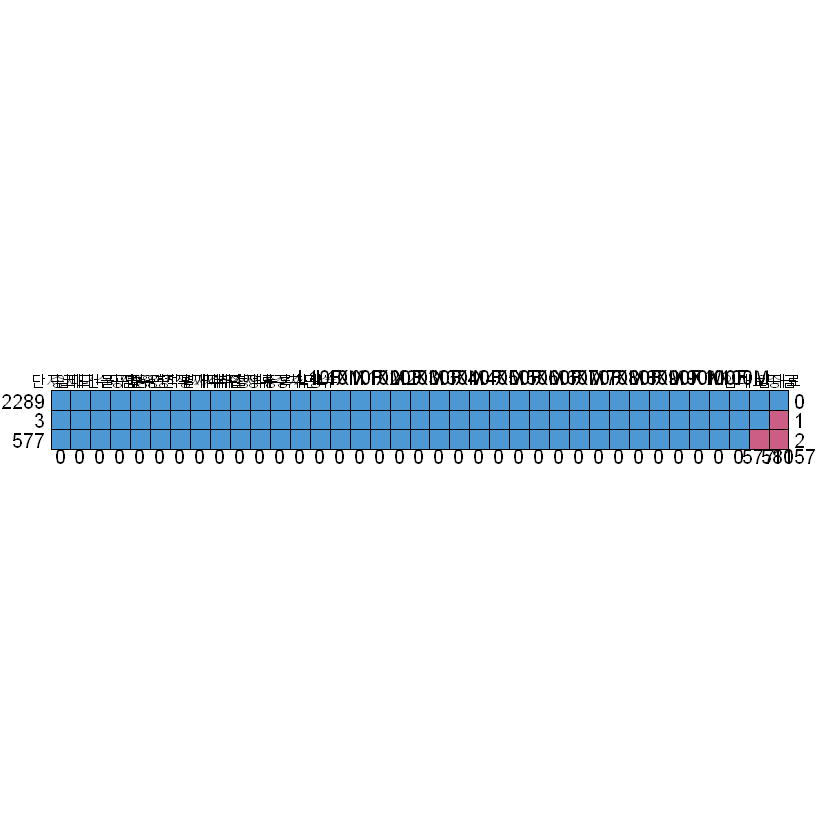

In [8]:
md.pattern(train)

In [13]:
m=20

In [16]:
imp<-mice( train   , m=m, method = "cart", seed=1, print=FALSE)

Warning message:
"Number of logged events: 200"

In [17]:
train<-read.csv("train.imp.csv", sep="," , header=T) 

Summarize the missing values in the data.